In [267]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [268]:
class Data():
    def __init__(self, filename):
        data = pd.read_pickle(filename)
        d_time = data.drop(columns=['X'])
        d_pos  = data.drop(columns=['T'])
        x = d_time.iloc[:, :].values
        y =  d_pos.iloc[:, :].values

        self.x = torch.tensor(x, requires_grad=True, dtype=torch.float)
        self.y = torch.tensor(y, requires_grad=True, dtype=torch.float)

    def __len__(self):
        return len(self.x)
    
    def __getparams__(self):
        return self.x, self.y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data  = Data('training-oha.pkl')  
vdata = Data('validation-oha.pkl') 
#data.__getparams__()

In [269]:
class OHAModel(nn.Module):
    def __init__(self):
        super(OHAModel, self).__init__()
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Tanh(), nn.Linear(32, 1)) # 1 InputL, 32 HiddenL, 1 OutputL

    def forward(self, x):
        out = self.linear(x)
        return out

model = OHAModel()
print(model)

OHAModel(
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [270]:
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

In [271]:
# Custom loss function:
# Função base:

class OHALoss(nn.Module):
    def __init__(self):
        super().__init__()

    def df(self, output : torch.Tensor, x: torch.Tensor = None, order : int=1) -> torch.Tensor:

        for _ in range(order):
            output = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
            
        return output


    def forward(self, x : torch.Tensor, x_physics : torch.Tensor, output : torch.Tensor, physics_output : torch.Tensor, target : torch.Tensor, mi, k, massa, epoch):
        # DE contribution
        LossDE = (massa)*self.df(physics_output, x_physics, order=2) + (mi)*self.df(physics_output, x_physics, order=1) + (k)*x_physics 

        #print(x_physics)

        # target contribution
        LossMSE = (output - target).pow(2).mean()
        

        Loss = LossMSE + (1e-4)*LossDE.pow(2).mean()
        #Loss = LossMSE

        return Loss





In [272]:
loss_func = OHALoss()
x_physics = torch.linspace(0,10,30, requires_grad=True).view(-1,1)

mi = 0.3
k = 3.24
massa = 1.0

epochs = 50000

for epoch in range(epochs):
    optimiser.zero_grad()

    outputs = model(data.x)
    physics_outputs = model(x_physics)

    loss = loss_func(data.x, x_physics, outputs, physics_outputs, data.y, mi, k, massa, epoch)
    loss.backward()
    
    optimiser.step()
    
    if epoch % 1000 == 0:
         print(f"Epoch: {epoch} - Loss: {float(loss.item()):>7f}")


Epoch: 0 - Loss: 6.573460
Epoch: 1000 - Loss: 5.659831
Epoch: 2000 - Loss: 5.174029
Epoch: 3000 - Loss: 4.630009
Epoch: 4000 - Loss: 4.053492
Epoch: 5000 - Loss: 3.498439
Epoch: 6000 - Loss: 2.992305
Epoch: 7000 - Loss: 2.539505
Epoch: 8000 - Loss: 2.130534
Epoch: 9000 - Loss: 1.756417
Epoch: 10000 - Loss: 1.416861
Epoch: 11000 - Loss: 1.115950
Epoch: 12000 - Loss: 0.861078
Epoch: 13000 - Loss: 0.661913
Epoch: 14000 - Loss: 0.519570
Epoch: 15000 - Loss: 0.418673
Epoch: 16000 - Loss: 0.343228
Epoch: 17000 - Loss: 0.285139
Epoch: 18000 - Loss: 0.242497
Epoch: 19000 - Loss: 0.209665
Epoch: 20000 - Loss: 0.179399
Epoch: 21000 - Loss: 0.153547
Epoch: 22000 - Loss: 0.133236
Epoch: 23000 - Loss: 0.113237
Epoch: 24000 - Loss: 0.099051
Epoch: 25000 - Loss: 0.087284
Epoch: 26000 - Loss: 0.074047
Epoch: 27000 - Loss: 0.066394
Epoch: 28000 - Loss: 0.060177
Epoch: 29000 - Loss: 0.054409
Epoch: 30000 - Loss: 0.049361
Epoch: 31000 - Loss: 0.046579
Epoch: 32000 - Loss: 0.044783
Epoch: 33000 - Loss: 0.

In [273]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


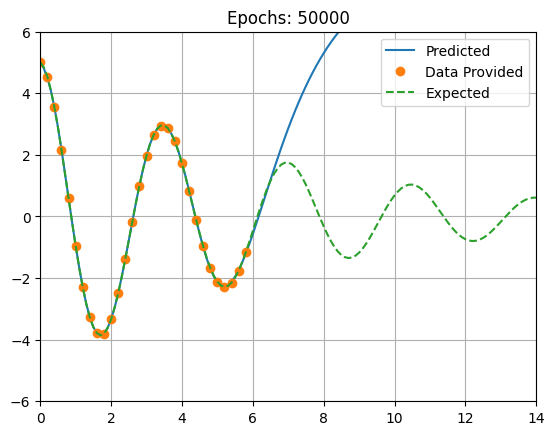

In [274]:
model = OHAModel()
model.load_state_dict(torch.load("model.pth"))

predicted = model(vdata.x)
vx = vdata.x.detach().numpy()
vy = vdata.y.detach().numpy()

x = data.x.detach().numpy()
y = data.y.detach().numpy()

plt.plot(vx, predicted.detach().numpy(), '-', label = 'Predicted')
plt.plot(x, y, 'o', label = 'Data Provided')
plt.plot(vx, vy, '--', label='Expected')
plt.xlim([0, 14])
plt.ylim([-6, 6])
plt.title(f'Epochs: {epochs}')
plt.legend(loc=1)
plt.grid(True)
plt.savefig('grafico-oha.jpg')
plt.show()